In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


""" 

Run Equilibrium Propagation / Backpropagation on Nanowire Networks for classification. 

Author: Alon Loeffler

Required Files/Folders: learning_functions.py | edamame | asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00.mat

"""

#IMPORTS:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally

fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
#point to network data path ^ 

saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs

" Create Inputs "
def createSimpleInputs(numSamples=10):
    #SIMPLE ROW INPUTS:
    np.random.seed(42)
    orig_inputs=np.array((np.array([1,0,1,1,0,1,0]),np.array([0,1,0,1,1,0,1])))
    orig_inputs=orig_inputs.astype('double')
    samples=[[] for i in range(len(orig_inputs))]
    new_inputs=np.array([orig_inputs]*numSamples)

    #Pattern without Noise
    NoNoiseInputs=[]
    for targetClass in range(len(orig_inputs)):
        NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])

    #Make Noisy variants of simple patterns:
    for i in range(len(orig_inputs)):
        for j in range(numSamples):
            randVals=np.random.randint(1,3) #choose how many of the 3 sources will have noise
            noiseVals=np.random.randint(3, size=randVals)
            temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
            for val in noiseVals:
                temp[val]=np.double(np.random.random(1))
            new_inputs[j][i][new_inputs[j][i]==1]=temp
    #         samples[i].append(temp)

    #RESHAPE INPUTS INTO numSamplesx2
    row1=[]
    row2=[]
    for i in range(len(new_inputs)):
        row1.append(new_inputs[i][0])
        row2.append(new_inputs[i][1])

    inputs=np.array([row1,row2])
    inputs=inputs.reshape(numSamples*2,orig_inputs.shape[1])
    targets=np.zeros(numSamples*2)
    targets[-numSamples:]=1

    #change 0 volts to 0.05
    minVoltage=0.005
    inputs=inputs+minVoltage
    
    return inputs, targets,orig_inputs

" Load Networks "
def buildNetworks(fileName,ManualSources=True):
    #load data
    nw=loadmat(fileName)
    nwSize = nw['number_of_wires'][0][0]
    this_seed=8639
    Network=nw
    connectivity=connectivity__(wires_dict=Network) 

    #fixing file structure from Matlab:
    connectivity.avg_length=connectivity.avg_length[0][0]
    connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
    connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
    connectivity.dispersion=connectivity.dispersion[0][0]
    # connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
    connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
    connectivity.length_x=connectivity.length_x[0][0]
    connectivity.length_y=connectivity.length_y[0][0]
    connectivity.number_of_wires=connectivity.number_of_wires[0][0]
    connectivity.numOfWires=connectivity.numOfWires[0][0]
    connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
    connectivity.theta=connectivity.theta[0][0]
    connectivity.this_seed=connectivity.this_seed[0][0]
    
    #find x and y values of each end of each wire 
    xa=connectivity.xa[0]
    xb=connectivity.xb[0]
    ya=connectivity.ya[0]
    yb=connectivity.yb[0]

    #Pick Electrode placement/distance apart:
    
    #DRAINS
    numDrains=3
    ex=np.ones(numDrains)*5#*15
    if nwSize > 500:
        eyVal=101
    else:
        eyVal= 51
    ey=np.linspace(-1,eyVal,numDrains)#(-1,101,numDrains)

    elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

    #SOURCES
    numSources=9

    #IN A LINE:
    if nwSize > 500:
        exVal=100
        eyVal = 99
    else:
        exVal=50
        eyVal=49
    ex=np.ones(numSources)*exVal#50
    ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)
    
    #IN A 3X3 GRID:
    # middleNWx=int(connectivity.length_x/2)+1
    # middleNWy=int(connectivity.length_y/2)-1
    # distBwElecs=10
    # ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
    # ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

    elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates



    #Manual Source Placement:
    if ManualSources:
        elecSource=[23,320,74,145, 228, 342, 141]
    else:    #remove middle drain and sources for simple patterns:
        elecSource=elecSource[[0,1,2,4,6,7,8]]
    elecDrain=elecDrain[[0,-1]]
    

    

    return connectivity,elecSource,elecDrain

#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
# def change_voltage(stim,sim2,outputVals,target_index,th=0,th2=0,signalType='DC'):
#     import copy
#     stimulus=copy.deepcopy(stim)
    
#     limitval = 1
    
#     Vi        = np.zeros((int(run_time/dt)))
#     maxV      = onAmp*limitval
#     n         = len(outputVals)
#     cost      = np.zeros(n)
#     beta      = 0.1 #change the values here
#     grad      = np.zeros((n))
#     dsig    = np.array([stimulus[i].signal for i in range(len(stimulus))][:num_drain_training])
    
#     #vectorised implementation
#     cost=calc_cost(outputVals,target_values) 
    
# #     if gradOff == False: #
#     grad=beta*(outputVals-target_values) 
# #     elif gradOff == True: #if we have hit currents target
# #         grad=0
#     dsig2=dsig.T+(grad*onAmp)
#     for i in range(n): # for each drain:
#         if stimulus[i].signal[0] <= maxV and stimulus[i].signal[0] >= -maxV:
#             set_trace()
#             stimulus[i].signal=dsig2.T[i]
        
#     print('Costs '+str(cost))
#     print('Sum Cost '+str((np.sum(cost))))
#     print('Gradients '+str(grad))
#     return outputVals,stimulus,cost

#ADD BACKPROP
#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,state,drains,sources,tmpTiming,tmpTargets,limVal,run_time=2,dt=0.01,disable_tqdm=False):
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                       stimulus = training_stimulus,
                       junctionMode = 'tunneling',
                       dt = dt, T = run_time, 
                       contactMode = 'preSet',
                       electrodes = eles,
                       findFirst = False,
                       start_state = state,
                       disable_tqdm=disable_tqdm,
                       collapse=True,tmpTiming=tmpTiming,tmpTargets=tmpTargets,limVal=limVal)  
    #     JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,cost   

#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None,tmpTiming=[],tmpTargets=[],limVal=0.5):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState,tmpTiming,tmpTargets,limVal, lite_mode, disable_tqdm, save_steps, **kwdict)
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost   

def simulateNetwork_backprop(simulationOptions, connectivity, junctionState,tmpTiming,tmpTargets, limVoltage,lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
    onAmp     = simulationOptions.stimulus[3].onAmp
    
#     limVoltage = 0.95#limit the drain voltage to a percentage of the onAmp
    maxV      = onAmp *limVoltage
    n         = num_drain_training #num of drains
    cost      = []
    beta      = 0.1
    grad      = np.zeros((n)) #set gradients to zero for each epoch  

    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])

    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    #Simulation Run:
#     new_time=0

    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        
        this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])
        
        if tmpTiming[this_time]=='Train':
#             print('--------')
#             print('Training')
#             print('--------\n')
            trainTime=True
        elif tmpTiming[this_time]=='Test':
#             print('--------')
#             print('Testing')
#             print('--------\n') 
            trainTime=False
        
        if trainTime and this_time > 0: #if we are training, change drain voltages, otherwise just use this_stimulus
            this_stimulus[:num_drain_training]=new_stimulus 
            
#             print('in training '+str(this_time))
#         elif this_time > trainTime:
            
        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]
            
        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff
        
        ## BackProp Implementation
        y = Network.electrodeCurrent[this_time,:num_drain_training]
        
        if tmpTargets[this_time] != -1: #skip rest values
            tarIdx=tmpTargets[this_time]
            y = y/(maxCurrent[tarIdx]) # normalize  | | | how do we change max current to be not arbitrary? 
            
        # current method - run simulation before with just that drain and use current as maxCurrent

            # change to threshold 
            d = allTargets[tarIdx]
            dsig = this_stimulus[:num_drain_training]


            #vectorised implementation
            cost.append(calc_cost(y,d))

            if trainTime: #if we are training, update beta
                #Gradient without considering other electrodes:
        # 
                grad=beta*(y-d) #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]
                #Gradient while considering other electrodes:
        #         for i in range(n): #for each drain 
                    #y = normalised drain current
                    #d = target (1 or 0) e.g. [1,0,0]

        #             grad[i] = beta*(y[i]-d[i]) + sum([beta*(y[j]-d[j]) for j in range(n) if j != i])
                    # i = 1, drain 1 is target, target = 1
                    # i = 2, drain 2 is target, target = 0

                #grad_i = (y_i - d_i) + SUM[ beta*(y_j - d_j) ], j \neq (doesn't equal) i        
                dsig2=np.array(dsig.T+(grad*onAmp))

                dsig2[tmpTargets[this_time]]=0
                new_stimulus=dsig2

                for q in range(n): # for each drain:
                    if dsig2[q] <= maxV and dsig2[q] >= -maxV:
                        new_stimulus[q]=dsig2[q]
                    elif dsig2[q] < -maxV:
                        new_stimulus[q]=-maxV
                    elif dsig2[q] > maxV:
                        new_stimulus[q]=maxV  

#                 tmp=range(0,niterations,numDT)
             
#             else:
#                 tmp=range(0,niterations,numDT)

#             new_time+=1
            
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
        
    return Network,cost



def runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks=[],maxCurrent=[1e-5,1e-5],limVal=0.5,seed=42,accThreshold=False):
    """
    n-back task:
    input sample 1 with backprop, then sample 2 with backprop, then sample 1 again with reset drain voltages 
    n back here = 1, showing memory
    
    train sample x, test sample x + nback (e.g. nback = 2, sample = [s1 train,s2,s3,s1 test] )

    increase n-back: 
    sample 1 with backprop, sample 2, sample 3... test sample 1 - n=2
    
    Things to test:
    - if we increase input frequency (dt), do we see greater long term memory? (higher n-backs)
    - if we decrease frequency, do we see greater short term memory? (lower n-backs)

    """  
    
    t           = [[] for i in range(len(nbacks))]
    simVoltages = []
    saveStim    = []
    accuracy    = []
    count=0
    for nback in nbacks: #how many samples to "remember" in the past before testing
        np.random.seed(seed)
        
        numTestingSamples= 20 #how many samples across all nback values
        
        #If we want to make sure there's equal samples:
        # #split into class 1 and class 2
#         class1Training= np.random.choice(len(trainingInputs[:int(len(trainingInputs)/2)]),size=int(len(trainingInputs)/2),replace=False)
#         class2Training= np.random.choice(len(trainingInputs[int(len(trainingInputs)/2):]),size=int(len(trainingInputs)/2),replace=False)
#         class2Training=class2Training+int(len(trainingInputs)/2)
#         orderTraining=np.insert(class2Training,np.arange(len(class1Training)),class1Training)

        #completely random order
        orderTraining = np.random.choice(len(trainingInputs),size=len(trainingInputs),replace=False)
        
        #DO WE NEED TO MAKE SURE WE HAVE EQUAL NUMBER OF Class 1 and Class 2?
        orderTrainingLabels=traininglabels[orderTraining]
        orderTrainingLabelsNBACK=orderTrainingLabels[::nback] #these are the testing labels - every i+nback training sample is what we're testing
        orderTesting=[]
        for label in orderTrainingLabelsNBACK: #for each training label in the random order:
            orderTesting.append(np.random.choice(np.where(testinglabels==label)[0]))
        orderTestingLabels=testinglabels[orderTesting]    
        orderTestingNBACK=np.array(orderTesting)+len(orderTraining) #number of test per nback
         #choose how many samples between testing samples:
        i = nback
        temp=[]
        j=0
        order=[None]*(len(orderTraining))
        order[:len(orderTraining)]=orderTraining
        while j<numTestingSamples: #for each testing sample 
            if i < len(order): #only if we are within the total number of training samples
                order.insert(i, orderTesting[j]+len(orderTraining)) #insert testing sample at ith position
            temp.append(i) #keep track number of inserts we made, make sure it == numTestingSamples
            i += nback+1
            j +=1
        
        
        #remove excess training (i.e. with no testing sample)
        sampleTimes=numDT*(nback+1)
        newTrainingOrder=orderTraining[:sampleTimes-numTestingSamples]
        orderTrainingLabels=orderTrainingLabels[:sampleTimes-numTestingSamples]
        order=order[:sampleTimes]

        #RUN SIM
        N                   = orig_inputs.shape[1]
        numClasses          = 2
        signalType          ='DC'
        num_drain_training  = 2
        num_source_training = N
        tmpSources          = [[] for i in range(len(order))]
        tmpTargets          = [None]*len(order)
        sim                 = [None]*len(order)
        numTrainingSamples  = len(trainingInputs)
        numTestingSamples   = len(testingInputs)
        timing=[]
        allLabels=[]
        i=0
        for val in order: #this method loops through samples in the randomised training order
            #are we training or testing?
            if val in orderTestingNBACK:
                test=True
                train=False
            elif val in orderTraining:
                test=False
                train=True
            #define samples
            if train: #if we're training
                this_sample = trainingInputs[val].copy() #xs
                this_label  = traininglabels[val] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmp #tune voltage based on onAmp
                timing.append('Train')

            elif test: #if we're testing
                this_sample = testingInputs[val-len(orderTraining)].copy() #xs
                this_label  = testinglabels[val-len(orderTraining)] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmpTest
                timing.append('Test')

            targetClassVals=[0,1] 

            targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
            timing[i] = signal_expand(timing[i],numDT)
        #     #array of nans:
            tmpArray=np.empty(restDur)
            tmpArray[:]=-1
            targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
            tmpTargets[i]=targetTmp 
        
            for j in range(len(this_sample)): #for each source electrode
                tmp = signal_expand(this_sample[j],numDT)
                tmp = np.append(tmp,np.zeros(restDur)) #add rest
                tmpSources[i].append(tmp)
                
            allLabels.append(this_label)
            i += 1

        #reshape inputs into 1d:
        tmpSources = np.hstack(np.array(tmpSources))
        tmpTargets = np.hstack(np.array(tmpTargets)).astype(int)
        tmpTiming = np.hstack(np.array(timing))
        # Change voltages
        newSources=tmpSources.copy()

        tmpDrain=[]
        stimulus=[]
        for j in range(num_drain_training): #create stimulus for each drain electrode
            stimulus.append(stimulus__(biasType='Drain',T=dt*len(newSources[j]),dt=dt))

        for j in range(len(tmpSources)): #create stimulus for each source electrode
            stimulus.append(stimulus__(biasType='Custom',T=dt*len(newSources[j]),dt=dt,customSignal=newSources[j]))
    
        signalLen=len(stimulus[0].signal) 
        
        #Run simulation
        sim,cost = getNWState_backprop(stimulus,None,drain_pool,sources,tmpTiming,tmpTargets,limVal,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)
        #Calculate electrode currents
        simVoltages.append(sim.wireVoltage)
        t[count].append(calcOutputs(sim,sources,drain_pool))
    
        #TESTING
        tmp=numDT*nback
        A=np.array(range(tmp,signalLen,int(tmp+numDT))) #training 
        B=np.array(range(tmp+numDT,signalLen,int(tmp+numDT)))# testing
        c=[]
        for k in range(len(B)):
            c.append(range(A[k],B[k]))
        testTimes=np.array(np.hstack(c))
        l=range(signalLen)
        trainTimes=np.array(np.hstack([m for m in l if m not in testTimes]))
        
        if accThreshold:
            #add threshold of difference to ensure accuracy:
            argmaxvals=np.argmax([t[count][0][0][testTimes],t[count][0][1][testTimes]],axis=0)

            for s in range(len(argmaxvals)):
                if abs(t[count][0][0][testTimes][s]-t[count][0][1][testTimes][s])>1e-6 and argmaxvals[s]==1:
                    argmaxvals[s]=1
                elif abs(t[count][0][0][testTimes][s]-t[count][0][1][testTimes][s])<1e-6 and argmaxvals[s] == 1:
                    argmaxvals[s]=0
            accuracy.append(np.sum(argmaxvals==tmpTargets[testTimes])/len(tmpTargets[testTimes]))
        else:
            accuracy.append(np.sum(np.argmax([t[count][0][0][testTimes],t[count][0][1][testTimes]],axis=0)==tmpTargets[testTimes])/len(tmpTargets[testTimes]))

        print(accuracy[count])
        
        #Draw:
        #Plot Test labels vs test argmax
#         plt.figure()
#         plt.plot(tmpTargets[testTimes],c='b')
#         plt.plot(np.argmax([t[count][0][0][testTimes],t[count][0][1][testTimes]],axis=0),alpha=0.5,c='r')
#         plt.legend(['Target','Argmax'])

#         plt.yticks([0,1])
#         ax=plt.gca()
#         ax.set_yticklabels(['Drain 1','Drain 2'])      
        
        count+=1
    
    return t,sim,stimulus,accuracy,tmpTargets,newTrainingOrder,orderTesting,order,orderTestingLabels,testTimes,trainTimes,numTestingSamples,allLabels,orderTrainingLabels

def trainTestSplit(inputs,targets,targetClassVals=[0,1],numTestingPerClass=3,orig_inputs=[]):
    trainingInputs  = np.array([inputs[targets==targetClassVals[0]][:-numTestingPerClass],inputs[targets==targetClassVals[1]][:-numTestingPerClass]]).reshape(-1,orig_inputs.shape[1])
    testingInputs   = np.array([inputs[targets==targetClassVals[0]][-numTestingPerClass:],inputs[targets==targetClassVals[1]][-numTestingPerClass:]]).reshape(-1,orig_inputs.shape[1])
    #Define Training and Testing labels
    traininglabels=np.zeros(len(trainingInputs))
    traininglabels[:int(len(trainingInputs)/2)]=0
    traininglabels[int(len(trainingInputs)/2):int(len(trainingInputs)/2)*2]=1
    # traininglabels[int(len(trainingInputs)/3)*2:]=2
    traininglabels=traininglabels.astype(int)

    testinglabels=np.zeros(len(testingInputs))
    testinglabels[:int(len(testingInputs)/2)]=0
    testinglabels[int(len(testingInputs)/2):int(len(testingInputs)/2)*2]=1
    # testinglabels[int(len(testingInputs)/3)*2:]=2
    testinglabels=testinglabels.astype(int)
    
    return trainingInputs,testingInputs,traininglabels,testinglabels


#TASK SETUP

print('Loading Networks + Training Data')
ManualSources=True
numSamples=50
inputs,targets,orig_inputs=createSimpleInputs(numSamples)
allTargets=[[1,0],[0,1]]

connectivity,sources,drain_pool=buildNetworks(fileName,ManualSources)

targetClassVals=[0,1]
numTestingPerClass=10
trainingInputs,testingInputs,traininglabels,testinglabels = trainTestSplit(inputs,targets,targetClassVals,numTestingPerClass,orig_inputs=orig_inputs)

num_drain_training=2
maxCurrent=[1e-5,1e-5]
# dts=[0.01,0.02,0.05,0.1]
dt=0.01

"Run n-back Task"
accThreshold=False #do we want to force a minimum (arbitrary) difference between target and non-target drain for accuracy to be counted?

Tlen = 200
timesteps   = Tlen/dt
numDT       = int(timesteps/len(inputs)) #number of timesteps per sample
restDur=0

#Amplitude:
# allAmpsTraining = [0.5,1,2,5] #Input voltage training
# allAmpsTesting  = [0.1,0.2,0.3,0.5] #Input voltage testing
onAmp = 1.5#allAmpsTraining[1]
onAmpTest = 0.25#allAmpsTesting[3]

#Other global variables:
num_drain_training = 2
maxCurrent = [1e-5,1e-5]

#RUN NBACKS
# nbacks = trial.suggest_int('nbacks', 1, 4) # sample integers uniformly
# nbacks = [nbacks]
nbacks         = [2]#range(1,5)
numRuns        = 10
t              = [None]*numRuns
sim            = [None]*numRuns
stimuli        = [None]*numRuns
accuracy       = [None]*numRuns

trainingOrder = [None]*numRuns
testingOrder = [None]*numRuns
testingLabels  = [None]*numRuns
trainingLabels  = [None]*numRuns
order          = [None]*numRuns
testTimes      = [None]*numRuns
trainTimes      = [None]*numRuns
targets        = [None]*numRuns
numTestingSamples = [None]*numRuns
allLabels      = [None]*numRuns
seeds          =  np.random.choice(10000,size=numRuns,replace=False)

#if we want to loop through onAmp limit voltage percentage for drains
limValues = [0.5]#list(np.arange(0.05,1.05,0.05))
#otherwise set a predefined percentage:
# limValues = [0.8]

meanAcc=[]
stdAcc=[]
for val in tqdm(limValues):
    print(val)
    for i in tqdm(range(numRuns)):
        t[i],sim[i],stimuli[i],accuracy[i],targets[i],trainingOrder[i],testingOrder[i],order[i],testingLabels[i],testTimes[i],trainTimes[i],numTestingSamples[i],allLabels[i],trainingLabels[i]=runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks,maxCurrent,val,seed=seeds[i],accThreshold=accThreshold)
        t[i]=t[i][0][0]
        
    meanAcc.append(np.mean(accuracy))
    stdAcc.append(np.std(accuracy))

Loading Networks + Training Data


  0%|          | 0/1 [00:00<?, ?it/s]

0.5


  0%|          | 0/10 [00:00<?, ?it/s]

Running Simulation :   0%|          | 0/20000 [00:00<?, ?it/s]

0.8854545454545455


Running Simulation :   0%|          | 0/20000 [00:00<?, ?it/s]

0.8748484848484849


Running Simulation :   0%|          | 0/20000 [00:00<?, ?it/s]

0.8790909090909091


Running Simulation :   0%|          | 0/20000 [00:00<?, ?it/s]

0.7954545454545454


Running Simulation :   0%|          | 0/20000 [00:00<?, ?it/s]

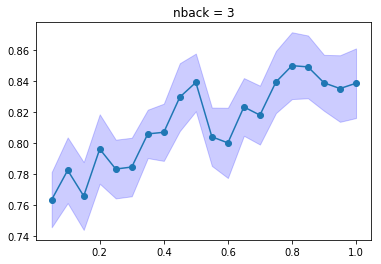

In [81]:
plt.plot(limValues,meanAcc,'-o')
sdError=stdAcc/np.sqrt(len(stdAcc))
plt.fill_between(limValues,np.array(meanAcc)+np.array(sdError),np.array(meanAcc)-np.array(sdError),color='b',alpha=0.2)
plt.title('nback = 3')
plt.savefig(saveFig+"voltage_limit_x_onAmp_drain_electrodes_vs_Accuracy_nback3.png")

In [61]:
seeds

array([7935, 8779, 8514, 3781, 2517, 7199, 4584, 3884, 8235, 1702])

In [415]:
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/GLMFIT/'

In [416]:
#take the first numDT*(nback+1) samples - these are the only ones with training + testing:
sampleTimes=numDT*(nbacks[0]+1)

In [417]:
import pandas as pd
# trainingLabels=allLabels #not sure about this
nback=nbacks[0]
thisTrainInputs=[[[] for i in range(sampleTimes-numTestingSamples[0])] for i in range(len(trainingLabels))]
for trial in tqdm(range(len(trainingLabels))): #for each trial
    #bin training samples
    thisLabels=np.array(allLabels[trial])
    tmp=trainingInputs[trainingOrder[trial]]
    
    #plot training inputs that are to be tested:
    count = 0
    for inpt in tmp:
        thisTrainInputs[trial][count]=(inpt.reshape(-1,1))
        count+=1
    trainlabel=trainingLabels[trial]
#     trainlabel=np.delete(trainlabel,np.arange(nback,trainlabel.size,nback+1))
    trainlabel=np.array(trainlabel).reshape(-1, nback)
    thisTestTime = testTimes[trial]
    currents=t[trial]
    thisTarget=targets[trial]
    testlabel=testingLabels[trial][:numTestingSamples[trial]]
    #argmax
    count = 0 
    temp=[]
    for i in range(numDT,(len(trainlabel)*numDT)+1,numDT):
        if count == 0:
            temp.append(np.sum(np.argmax([currents[0][thisTestTime[count:i]],currents[1][thisTestTime[count:i]]],axis=0)==targets[trial][thisTestTime[count:i]])/numDT)
        else:
#             set_trace()
            temp.append(np.sum(np.argmax([currents[0][thisTestTime[i-numDT:i]],currents[1][thisTestTime[i-numDT:i]]],axis=0)==targets[trial][thisTestTime[i-numDT:i]])/numDT)
        count+=1
      
    if nback == 1:
        
        c1notest=[0]
        c2notest=[0]
        count1=0
        count2=0
        c2count=[]
        c1count=[]
        classOrder=[]
        targetClass=[]
        for label in trainlabel:
            if np.all(label == [0]):
                classOrder.append('c1')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [1]):
                classOrder.append('c2')
                targetClass.append(2)
                count2+=1
            c2count.append(count2)
            c1count.append(count1)
       #count how many times the network has seen c1-c1,c1-c2/c2-c1,c2-c2 at each test point:
        for i in range(len(trainlabel)):
            a=np.sum(np.array_equiv(trainlabel[i],np.array([0])))
            b=np.sum(np.array_equiv(trainlabel[i],np.array([1])))
            
    #         set_trace()
            c1notest.append(c1notest[i]+a)
            c2notest.append(c2notest[i]+b)

        #count how many times the network has seen c1/c2 at each test point:
        count1notest=[]
        count2notest=[]
        temp1=trainlabel.reshape(-1)
        for i in range(len(temp1)):
            if i == 0:
                count1notest.append(0)
                count2notest.append(0)
            if i % nback == 0 and i > 0:
                count1notest.append(np.sum(temp1[:i]==0))
                count2notest.append(np.sum(temp1[:i]==1))
            
        count1plustest=[]
        count2plustest=[]
        temp1=thisLabels
        n=nback+1
        for i in range(len(temp1)):
            if i == 0:
                count1plustest.append(0)
                count2plustest.append(0)
            if i % n == 0 and i > 0: 
                count1plustest.append(np.sum(temp1[:i]==0))
                count2plustest.append(np.sum(temp1[:i]==1))            

        cumsumdiffnotest=np.array(count1notest)-np.array(count2notest)
        cumsumdifftest=np.array(count1plustest)-np.array(count2plustest)    
        
        df=pd.DataFrame({'Class':np.array(targetClass),'Order':classOrder,'Trial':trial,
                         'Accuracy':temp,'C1NoTest':count1notest,
                         'C2NoTest':count2notest,'CountDiff':np.array(c2count)-np.array(c1count),
                         'C1+Test':count1plustest,'C2+Test':count2plustest,
                         'C1count':c1notest[1:], 'C2count':c2notest[1:],
                        })
    
        
        
    elif nback == 2:    
        #seperate to classes 

        c1c1notest=[0]
        c1c2notest=[0]
        c2c1notest=[0]
        c2c2notest=[0]
        count1=0
        count2=0
        c2count=[]
        c1count=[]
        classOrder=[]
        targetClass=[]
        for label in trainlabel:
            if np.all(label == [0,0]):
                classOrder.append('c1-c1')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [0,1]):
                classOrder.append('c1-c2')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [1,1]):
                classOrder.append('c2-c2')
                targetClass.append(2)
                count2+=1
            elif np.all(label == [1,0]):
                classOrder.append('c2-c1')
                targetClass.append(2)
                count2+=1
            c2count.append(count2)
            c1count.append(count1)
       #count how many times the network has seen c1-c1,c1-c2/c2-c1,c2-c2 at each test point:
        for i in range(len(trainlabel)):
            a=np.sum(np.array_equiv(trainlabel[i],np.array([0,0])))
            b=np.sum(np.array_equiv(trainlabel[i],np.array([0,1])))
            c=np.sum(np.array_equiv(trainlabel[i],np.array([1,0])))
            d=np.sum(np.array_equiv(trainlabel[i],np.array([1,1])))

    #         set_trace()
            c1c1notest.append(c1c1notest[i]+a)
            c1c2notest.append(c1c2notest[i]+b)
            c2c1notest.append(c2c1notest[i]+c)
            c2c2notest.append(c2c2notest[i]+d)


        #count how many times the network has seen c1/c2 at each test point:
        count1notest=[]
        count2notest=[]
        temp1=trainlabel.reshape(-1)
        for i in range(len(temp1)):
            if i == 0:
                count1notest.append(0)
                count2notest.append(0)
            if i % nback == 0 and i > 0:
                count1notest.append(np.sum(temp1[:i]==0))
                count2notest.append(np.sum(temp1[:i]==1))

        count1plustest=[]
        count2plustest=[]
        temp1=thisLabels
        n=nback+1
        for i in range(len(temp1)):
            if i == 0:
                count1plustest.append(0)
                count2plustest.append(0)
            if i % n == 0 and i > 0: 
                count1plustest.append(np.sum(temp1[:i]==0))
                count2plustest.append(np.sum(temp1[:i]==1))            

        cumsumdiffnotest=np.array(count1notest)-np.array(count2notest)
        cumsumdifftest=np.array(count1plustest)-np.array(count2plustest)    


        df=pd.DataFrame({'Class':np.array(targetClass),'Order':classOrder,'Trial':trial,
                         'Accuracy':temp,'C1NoTest':count1notest,
                         'C2NoTest':count2notest,'CountDiff':np.array(c2count)-np.array(c1count),
                         'C1+Test':count1plustest,'C2+Test':count2plustest,'C1C1count':c1c1notest[1:],
                         'C1C2count':c1c2notest[1:], 'C2C1count':c2c1notest[1:],'C2C2count':c2c2notest[1:],
                        })
    
    elif nback == 3:    

        count1=0
        count2=0
        c2count=[]
        c1count=[]
        classOrder=[]
        targetClass=[]
        for label in trainlabel:
            if np.all(label == [0,0,0]):
                classOrder.append('c1-c1-c1')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [0,1,0]):
                classOrder.append('c1-c2-c1')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [0,1,1]):
                classOrder.append('c1-c2-c2')
                targetClass.append(1)
                count1+=1
            elif np.all(label == [0,0,1]):
                classOrder.append('c1-c1-c2')
                targetClass.append(1)
                count1+=1   
            elif np.all(label == [1,1,1]):
                classOrder.append('c2-c2-c2')
                targetClass.append(2)
                count2+=1
            elif np.all(label == [1,0,1]):
                classOrder.append('c2-c1-c2')
                targetClass.append(2)
                count2+=1
            elif np.all(label == [1,1,0]):
                classOrder.append('c2-c2-c1')
                targetClass.append(2)
                count2+=1
            elif np.all(label == [1,0,0]):
                classOrder.append('c2-c1-c1')
                targetClass.append(2)
                count2+=1
            c2count.append(count2)
            c1count.append(count1)
       #count how many times the network has seen c1-c1,c1-c2/c2-c1,c2-c2 at each test point:
        c1c1c1notest=[0];c2c2c2notest=[0];
        c1c1c2notest=[0];c2c2c1notest=[0];
        c1c2c2notest=[0];c2c1c2notest=[0];
        c1c2c1notest=[0];c2c1c1notest=[0];
        
        for i in range(len(trainlabel)):
            a1=np.sum(np.array_equiv(trainlabel[i],np.array([0,0,0])))
            b1=np.sum(np.array_equiv(trainlabel[i],np.array([0,0,1])))
            c1=np.sum(np.array_equiv(trainlabel[i],np.array([0,1,0])))
            d1=np.sum(np.array_equiv(trainlabel[i],np.array([0,1,1])))
            a2=np.sum(np.array_equiv(trainlabel[i],np.array([1,1,1])))
            b2=np.sum(np.array_equiv(trainlabel[i],np.array([1,0,1])))
            c2=np.sum(np.array_equiv(trainlabel[i],np.array([1,1,0])))
            d2=np.sum(np.array_equiv(trainlabel[i],np.array([1,0,0])))
            
    #         set_trace()
            c1c1c1notest.append(c1c1c1notest[i]+a1)
            c1c1c2notest.append(c1c1c2notest[i]+b1)
            c1c2c1notest.append(c1c2c1notest[i]+c1)
            c1c2c2notest.append(c1c2c1notest[i]+d1)
            c2c2c2notest.append(c2c2c2notest[i]+a2)
            c2c1c2notest.append(c1c1c2notest[i]+b2)
            c2c2c1notest.append(c1c2c1notest[i]+c2)
            c2c1c1notest.append(c1c2c1notest[i]+d2)


        #count how many times the network has seen c1/c2 at each test point:
        count1notest=[]
        count2notest=[]
        temp1=trainlabel.reshape(-1)
        for i in range(len(temp1)):
            if i == 0:
                count1notest.append(0)
                count2notest.append(0)
            if i % nback == 0 and i > 0:
                count1notest.append(np.sum(temp1[:i]==0))
                count2notest.append(np.sum(temp1[:i]==1))

        count1plustest=[]
        count2plustest=[]
        temp1=thisLabels
        n=nback+1
        for i in range(len(temp1)):
            if i == 0:
                count1plustest.append(0)
                count2plustest.append(0)
            if i % n == 0 and i > 0: 
                count1plustest.append(np.sum(temp1[:i]==0))
                count2plustest.append(np.sum(temp1[:i]==1))            

        cumsumdiffnotest=np.array(count1notest)-np.array(count2notest)
        cumsumdifftest=np.array(count1plustest)-np.array(count2plustest)    

        df=pd.DataFrame({'Class':np.array(targetClass),'Order':classOrder,'Trial':trial,
                         'Accuracy':temp,'C1NoTest':count1notest,
                         'C2NoTest':count2notest,'CountDiff':np.array(c2count)-np.array(c1count),
                         'C1+Test':count1plustest,'C2+Test':count2plustest,'C1C1C1count':c1c1c1notest[1:],
                         'C1C1C2count':c1c1c2notest[1:],'C1C2C2count':c1c2c2notest[1:],'C1C2C1count':c1c2c1notest[1:],
                         'C2C2C2count':c2c2c2notest[1:],'C2C2C1count':c2c2c1notest[1:],'C2C1C1count':c2c1c1notest[1:],
                         'C2C1C2count':c2c1c2notest[1:]
                        })
        
    counts=[]
    for i in range(len(df)):
        counts.append(i)
        
    d = {'OrderVal':counts,'Train Time Start':((np.array(counts)+1)*numDT*3)-numDT*3,
                     'Train Time End':((np.array(counts)+1)*numDT*3)-numDT-1,
                     'Test Time Start':(np.array(counts)+1)*numDT*3-numDT,
                     'Test Time End':(np.array(counts)+1)*numDT*3-1,}
    df = df.join(pd.DataFrame(d, index=df.index))
    
    if trial == 0:
        newdf=df
    else:
        newdf=newdf.append(df)
    newdf.index=range(len(newdf))

  0%|          | 0/10 [00:00<?, ?it/s]

In [418]:
nback

3

In [419]:
df[:-1]

,Class,Order,Trial,Accuracy,C1NoTest,C2NoTest,CountDiff,C1+Test,C2+Test,C1C1C1count,...,C1C2C1count,C2C2C2count,C2C2C1count,C2C1C1count,C2C1C2count,OrderVal,Train Time Start,Train Time End,Test Time Start,Test Time End
0,2,c2-c2-c2,9,1.0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,39,40,59
1,1,c1-c2-c2,9,0.0,0,3,0,0,4,0,...,0,1,0,0,0,1,60,99,100,119
2,1,c1-c2-c2,9,0.0,1,5,-1,2,6,0,...,0,1,0,0,0,2,120,159,160,179
3,1,c1-c1-c1,9,1.0,2,7,-2,4,8,1,...,0,1,0,0,0,3,180,219,220,239
4,2,c2-c1-c2,9,1.0,5,7,-1,8,8,1,...,0,1,0,0,1,4,240,279,280,299
5,2,c2-c1-c2,9,0.0,6,9,0,9,11,1,...,0,1,0,0,1,5,300,339,340,359
6,2,c2-c1-c1,9,1.0,7,11,1,10,14,1,...,0,1,0,1,0,6,360,399,400,419
7,2,c2-c1-c1,9,1.0,9,12,2,12,16,1,...,0,1,0,1,0,7,420,459,460,479
8,2,c2-c2-c1,9,0.0,11,13,3,14,18,1,...,0,1,1,0,0,8,480,519,520,539
9,1,c1-c1-c1,9,1.0,12,15,2,15,21,2,...,0,1,0,0,0,9,540,579,580,599


In [357]:
print(len(np.where(list(newdf['Accuracy']<1))[0]))
len(np.where(list(newdf['Accuracy']==1))[0])

65


135

Text(0.5, 1.0, 'CumCount Pairings and Accuracy | C2 Pairings')

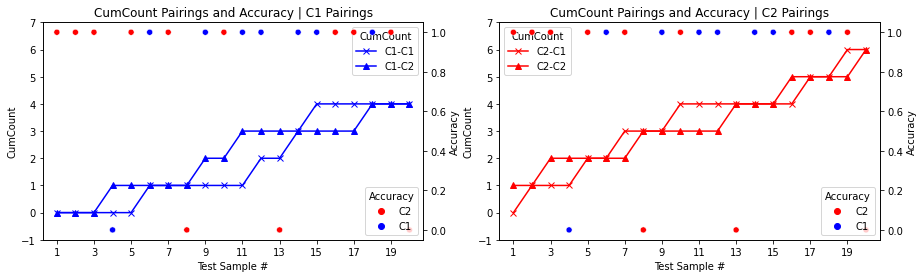

In [266]:
import seaborn as sns

fig,axes=plt.subplots(1,2,figsize=(15,4))

ax=axes[0]

p1=ax.plot(range(len(c1c1notest[1:])),c1c1notest[1:],color='b',marker='x')
p2=ax.plot(range(len(c1c2notest[1:])),c1c2notest[1:],color='b',marker='^')
ax.legend([p1[0],p2[0]],['C1-C1','C1-C2'],loc='best',title='CumCount')

ax.set_xlim([-0.75,19.75])
ax.set_ylim([-1,7])
ax.set_ylabel('CumCount')
ax.set_xlabel('Test Sample #')

ax.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax2=ax.twinx()
# plt.plot(temp,'o',c='k')

colrs=[]
for val in df['Class']:
    if val <= 1:
        colrs.append('C1')
    else:
        colrs.append('C2')
        
        
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['r','b'],ax=ax2)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
plt.legend(title='Accuracy',loc='lower right')
ax2.set_title('CumCount Pairings and Accuracy | C1 Pairings')
# plt.plot(np.array(targetClass)-1,'_')

ax1=axes[1]
p3=ax1.plot(range(len(c2c1notest[1:])),c2c1notest[1:],color='r',marker='x')
p4=ax1.plot(range(len(c2c2notest[1:])),c2c2notest[1:],color='r',marker='^')
ax1.legend([p3[0],p4[0]],['C2-C1','C2-C2'],loc='best',title='CumCount')
ax1.set_xlim([-0.75,19.75])
ax1.set_ylim([-1,7])
ax1.set_ylabel('CumCount')
ax1.set_xlabel('Test Sample #')

ax1.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax1.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax3=ax1.twinx()
      
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['r','b'],ax=ax3)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
ax3.legend(title='Accuracy',loc='lower right')
ax3.set_title('CumCount Pairings and Accuracy | C2 Pairings')
# plt.plot(np.array(targetClass)-1,'_')

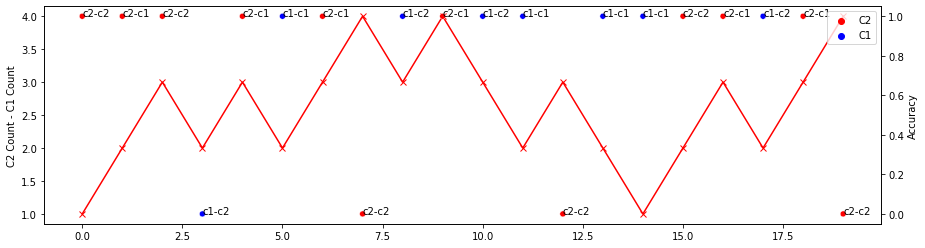

In [267]:

fig,ax=plt.subplots(1,figsize=(15,4))

colrs=[]
for val in df['Class']:
    if val <= 1:
        colrs.append('C1')
    else:
        colrs.append('C2')


x=newdf['CountDiff'][-20:]

p1=ax.plot(range(len(x)),x,color='r',marker='x')
ax2=ax.twinx()

sns.scatterplot(x='OrderVal',y='Accuracy',data=newdf[-20:],hue=colrs,palette=['r','b'],ax=ax2)
ax.set_ylabel('C2 Count - C1 Count')

z=newdf[-20:]['OrderVal'].values
y=newdf[-20:]['Accuracy'].values
for i, txt in enumerate(newdf[-20:]['Order']):
    ax2.annotate(txt, (z[i], y[i]))
# p2=ax.plot(range(len(c1c2notest[1:])),c1c2notest[1:],color='b',marker='^')
# ax.legend([p1[0],p2[0]],['C1-C1','C1-C2'],loc='best',title='CumCount')


In [268]:
meanC1NoTest=newdf.groupby('OrderVal').mean()['C1NoTest'].values
meanC2NoTest=newdf.groupby('OrderVal').mean()['C2NoTest'].values
stdC1NoTest=newdf.groupby('OrderVal').std()['C1NoTest'].values
stdC2NoTest=newdf.groupby('OrderVal').std()['C2NoTest'].values


Text(0.5, 1.0, 'CumCount Class and Accuracy | With Test Values')

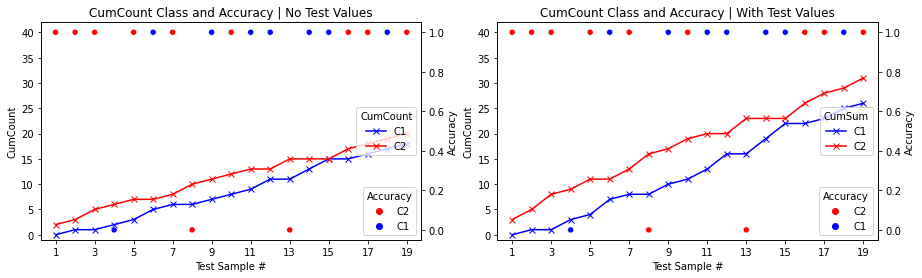

In [269]:
fig,axes=plt.subplots(1,2,figsize=(15,4))

ax=axes[0]

p1=ax.plot(range(len(count1notest[1:])),count1notest[1:],color='b',marker='x')
p2=ax.plot(range(len(count2notest[1:])),count2notest[1:],color='r',marker='x')
ax.legend([p1[0],p2[0]],['C1','C2'],loc='right',title='CumCount')

ax.set_xlim([-0.75,18.75])
ax.set_ylim([-1,42])
ax.set_ylabel('CumCount')
ax.set_xlabel('Test Sample #')

ax.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax2=ax.twinx()
# plt.plot(temp,'o',c='k')

colrs=[]
for val in df['Class']:
    if val <= 1:
        colrs.append('C1')
    else:
        colrs.append('C2')
        
        
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['r','b'],ax=ax2)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
plt.legend(title='Accuracy',loc='lower right')
ax2.set_title('CumCount Class and Accuracy | No Test Values')
# plt.plot(np.array(targetClass)-1,'_')

ax1=axes[1]
p1=ax1.plot(range(len(count1plustest[1:])),count1plustest[1:],color='b',marker='x')
p2=ax1.plot(range(len(count2plustest[1:])),count2plustest[1:],color='r',marker='x')
ax1.legend([p1[0],p2[0]],['C1','C2'],loc='right',title='CumSum')
ax1.set_xlim([-0.75,18.75])
ax1.set_ylim([-1,42])
ax1.set_ylabel('CumCount')
ax1.set_xlabel('Test Sample #')

ax1.set_xticks(np.array(np.arange(0,len(count2notest[1:]),2)))

ax1.set_xticklabels(np.array(np.arange(0,len(count2notest[1:]),2))+1)
ax3=ax1.twinx()
      
sns.scatterplot(x='OrderVal',y='Accuracy',data=df,hue=colrs,palette=['r','b'],ax=ax3)
# p3=plt.scatter(np.array(range(len(targetClass))),temp,marker='x',color=colrs,label=['C1','C2'])
ax3.legend(title='Accuracy',loc='lower right')
ax3.set_title('CumCount Class and Accuracy | With Test Values')
# plt.plot(np.array(targetClass)-1,'_')

Text(0, 0.5, 'Accuracy')

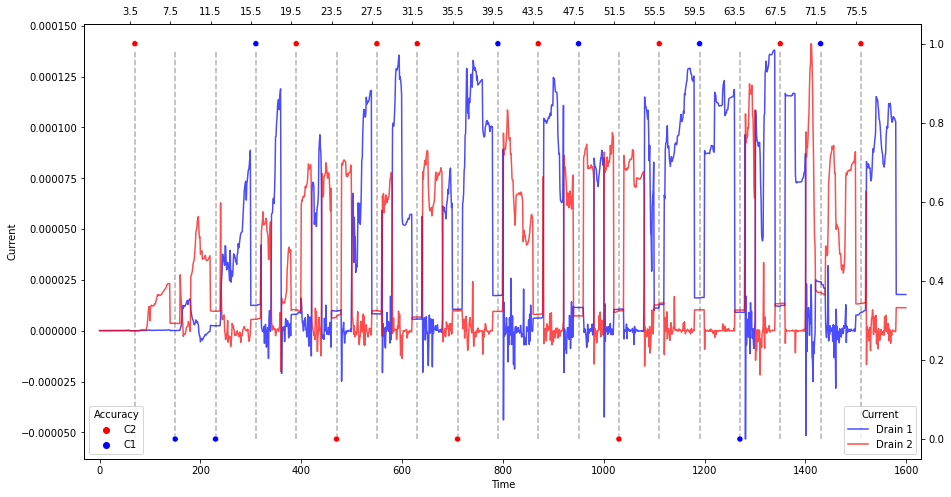

In [420]:
#Current Strength vs Accuracy:
plt.figure(figsize=(15,8))
x=t[-1][0]
p1=plt.plot(x,'b',alpha=0.7)
p2=plt.plot(t[-1][1],'r',alpha=0.7)
plt.legend([p1[0],p2[0]],['Drain 1','Drain 2'],loc='lower right',title='Current')


if nback == 1:
    xlimmax=830
    vlinesStep=40
    vlinesStart=30
    dotpos=2

if nback == 2:
    xlimmax=1230
    vlinesStep=60
    vlinesStart=50
    dotpos=3
elif nback == 3:
    xlimmax=1630
    vlinesStep=80
    vlinesStart=70
    dotpos=4
    
colrs=[]
for val in df['Class']:
    if val <= 1:
        colrs.append('C1')
    else:
        colrs.append('C2')    

plt.vlines(range(vlinesStart,len(x)-20,vlinesStep),np.min(x),np.max(x),linestyle='dashed',color='k',alpha=0.3)
ax=plt.gca()
ax.set_xlabel('Time')
ax.set_ylabel('Current')
ax.set_xlim([-30,xlimmax])


ax2=ax.twinx().twiny()

ax2.set_xticks(np.array(range(vlinesStart,len(x)-10,vlinesStep))/20)

testTimeVals=list(df['OrderVal']*dotpos+dotpos)


sns.scatterplot(x=testTimeVals[:-1],y='Accuracy',data=df[:-1],hue=colrs[:-1],palette=['r','b'],ax=ax2)
ax2.legend(title='Accuracy',loc='lower left')
ax2.set_xlim([-20/20,(xlimmax+10)/20])
ax2.set_ylabel('Accuracy')

# ax3=ax2.twinx()
# p1=ax3.plot(testTimeVals[:-1],count1plustest[:-1],color='c',marker='x')
# p2=ax3.plot(testTimeVals[:-1],count2plustest[:-1],color='m',marker='x')
# ax3.set_xlim([-20/20,1240/20])

# plt.vlines(range(3,testTimeVals.values[-1],3),0,1,linestyle='dashed',color='k',)


In [421]:
newdf.Accuracy.mean()

0.7964999999999999

In [422]:
newdfAccuracy = newdf.groupby('Order').agg([np.mean,np.std])
newdfAccuracy= newdfAccuracy['Accuracy']

In [423]:
newdfAccuracy

,mean,std
Order,,
c1-c1-c1,0.837037,0.363898
c1-c1-c2,0.796667,0.391183
c1-c2-c1,0.877586,0.313274
c1-c2-c2,0.869355,0.340264
c2-c1-c1,0.694643,0.459134
c2-c1-c2,0.568000,0.498932
c2-c2-c1,0.884091,0.299756
c2-c2-c2,0.836957,0.350395


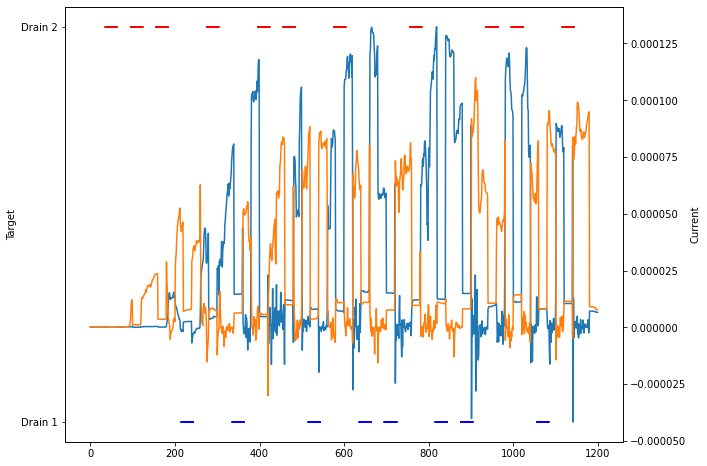

In [281]:
trial=-1
triallen=len(t[trial][0])
plt.figure(figsize=(10,8))
mask=np.in1d(np.arange(triallen),thisTestTime)
a=targets[trial].astype(float)
a[~mask]=np.nan
clrs=[]
for val in a:
    if val > 0:
        clrs.append('r')
    else:
        clrs.append('b')
plt.scatter(np.arange(triallen),a,marker='_',color=clrs)
ax=plt.gca()
# ax.set_xlim([600,1000])
plt.yticks([0,1])
ax.set_ylabel('Target')
ax.set_yticklabels(['Drain 1','Drain 2'])
ax2=plt.twinx()
ax2.set_ylabel('Current')
plt.plot(t[trial][0])
plt.plot(t[trial][1])


In [424]:
## EXPLORE SAMPLE CASES OF 0 and 1 accuracies:
trialNum=newdf[-20:]['Trial']
trialNum=trialNum.values[0]
sampleOrder=newdf[-20:]['OrderVal']

In [425]:
pwd

'/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp/n-back'

In [426]:
with open('nback3-manual-elecs-nw350-nj1350', 'wb') as f:
    pickle.dump([newdf[-20:],sim[trialNum],targets[trialNum],testTimes[trialNum],trainingInputs[trainingOrder[-1]],testingInputs[testingOrder[-1]]], f)   

In [2885]:
xlims=[newdf['Train Time Start'].values[0],df['Test Time End'].values[-1]]

In [2886]:
trialNum

9

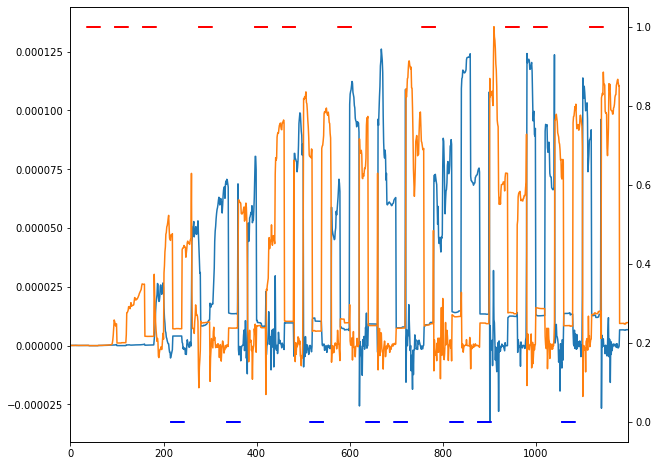

In [2899]:
plt.figure(figsize=(10,8))
plt.plot(sim[trialNum].electrodeCurrent[:,:2])
ax=plt.gca()
ax.set_xlim(xlims)
ax2=plt.twinx()
ax2.set_xlim(xlims)
plt.scatter(np.arange(triallen),a,marker='_',color=clrs)


In [2900]:
## EXPLORE ACCURACY

Text(0.5, 0, 'Accuracy')

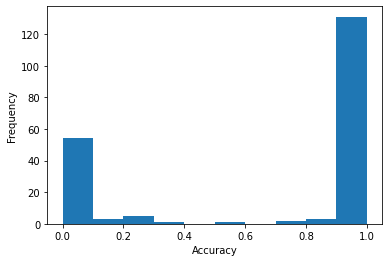

In [2901]:
ax=newdf['Accuracy'].plot(kind='hist')
ax.set_xlabel('Accuracy')

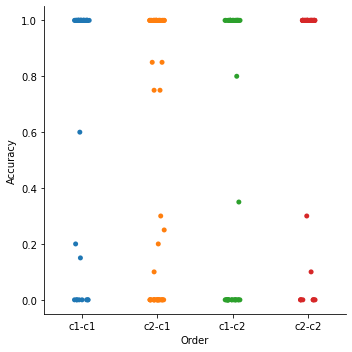

In [2902]:
sns.catplot(x='Order',y='Accuracy',data=newdf)

Text(0, 0.5, 'Sample #')

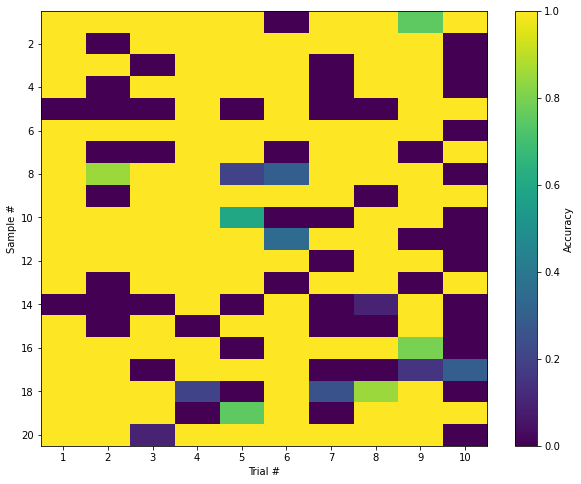

In [2903]:
# plt.imshow(np.array(newdf.Accuracy).reshape(-1,20),aspect='auto')
plt.figure(figsize=(10,8))
plt.imshow(np.array(newdf.Accuracy).reshape(numTestingSamples[trial],-1),aspect='auto')
plt.colorbar(label='Accuracy')
plt.xticks(np.array(np.arange(0,numRuns,1)))
ax=plt.gca()
ax.set_xticklabels(np.array(np.arange(1,numRuns+1,1)))

plt.yticks(np.array(np.arange(1,numTestingSamples[trial],2)))

ax.set_yticklabels(np.array(np.arange(2,numTestingSamples[trial]+1,2)))


ax.set_xlabel('Trial #')
ax.set_ylabel('Sample #')

Text(0, 0.5, 'Training Sample #')

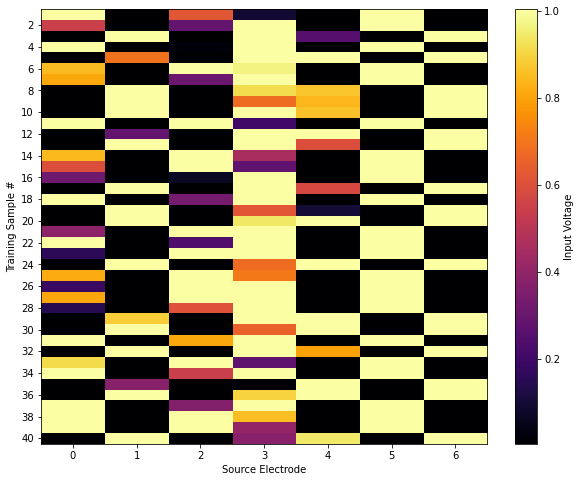

In [2904]:
plt.figure(figsize=(10,8))
trial=0
plt.imshow(np.array(thisTrainInputs[trial]).reshape(sampleTimes-numTestingSamples[trial],7),aspect='auto',cmap=plt.cm.inferno)
ax=plt.gca()
plt.yticks(np.array(np.arange(1,sampleTimes-numTestingSamples[trial],2)))

ax.set_yticklabels(np.array(np.arange(2,sampleTimes-numTestingSamples[trial]+1,2)))

plt.colorbar(label='Input Voltage')
ax.set_xlabel('Source Electrode')
ax.set_ylabel('Training Sample #')


In [2905]:
newdfOrderAccuracy=newdf.groupby(['Order','OrderVal']).agg([np.mean,np.std])
newdfOrderAccuracy= newdfOrderAccuracy['Accuracy']

In [2112]:

# c1df=newdf.loc[newdf['Class']==1]

# g=sns.catplot(ax=ax,data=newdf,kind='count',x='OrderVal',hue='Order')
# g.fig.set_size_inches(20,8)

# # newdfOrderAccuracy.plot(marker='o',y='mean',yerr='std')
# # ax=plt.gca()
# # ax.set_ylabel('Accuracy')

In [2907]:
dfc1c2=pd.DataFrame(newdf.Accuracy[newdf.Order=='c1-c2'].sort_index())
dfc1c1=pd.DataFrame(newdf.Accuracy[newdf.Order=='c1-c1'].sort_index())

Text(0.5, 0, 'Sample #')

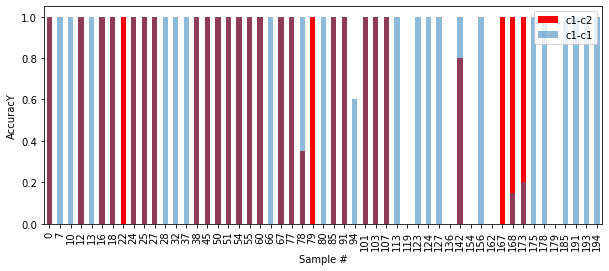

In [2908]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
yerr=dfc1c2.groupby(dfc1c2.index).std().values.flatten()

dfc1c2.groupby(dfc1c2.index).mean().plot(kind='bar',yerr=yerr,label='c1-c2',ax=ax,color='r',error_kw=dict(ecolor='r',elinewidth=2,capsize=5))

yerr=dfc1c1.groupby(dfc1c1.index).std().values.flatten()

dfc1c1.groupby(dfc1c1.index).mean().plot(kind='bar',yerr=yerr,label='c1-c1',alpha=0.5,ax=ax,error_kw=dict(ecolor='b',elinewidth=2,capsize=5))

ax.legend(["c1-c2", "c1-c1"]);

plt.ylabel('AccuracY')

ax.set_xlabel('Sample #')
# plt.plot(y,'-x',c='r',label='c1-c2')
# x=range(len(y))
# plt.fill_between(x,y+yerr,y-yerr,color='r',alpha=0.5)
# y=dfc1c1.groupby(dfc1c1.index).mean().values.flatten()
# yerr=dfc1c1.groupby(dfc1c1.index).std().values.flatten()
# plt.plot(y,'-x',c='b',label='c1-c1')
# x=range(len(y))
# plt.fill_between(x,y+yerr,y-yerr,color='b',alpha=0.5)
# plt.xticks(np.array(np.arange(0,20,1)))
# ax=plt.gca()

# ax.set_xticklabels(np.array(np.arange(1,21,1)))


[Text(0, 0, 'Drain 1'), Text(0, 1, 'Drain 2')]

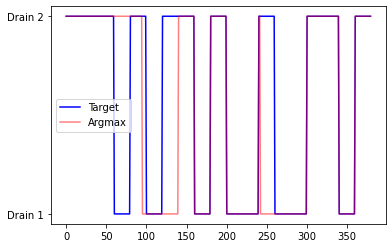

In [2910]:
plt.plot(thisTarget[thisTestTime],c='b')
plt.plot(np.argmax([currents[0][thisTestTime],currents[1][thisTestTime]],axis=0),alpha=0.5,c='r')
plt.legend(['Target','Argmax'])

plt.yticks([0,1])
ax=plt.gca()
ax.set_yticklabels(['Drain 1','Drain 2'])


In [310]:
# import pandas as pd
# plt.style.use('ggplot')

# y=np.mean(accuracy,axis=0)
# yerr=np.std(accuracy,axis=0)

# df=pd.DataFrame({'Mean':y,'STD':yerr})
# meansum =df['Mean']
# stdsum=df['STD']

# fig,ax=plt.subplots(1)
# my_colors = ['r','g','b','m']
# plot = meansum.plot(kind='bar',yerr=stdsum,color=my_colors,edgecolor='black',grid=False,ax=ax,error_kw=dict(ecolor='k',elinewidth=2,capsize=5),width=0.8,rot=0)
# ax.set_ylim([0,1.02])
# ax.set_facecolor('white')
# ax.set_xticklabels([1,2,3,4])
# ax.set_xlabel('n-back')
# ax.set_ylabel('Accuracy')

### SAVE DATA FOR GLMFIT (mac's idea)

In [427]:
vt=sim[9].wireVoltage
vtj=sim[9].junctionVoltage
gtj=sim[9].junctionConductance
ctj=vtj*gtj

In [428]:
tar=targets[9]

In [429]:
print(nback)

3


In [430]:
savemat(dataLoc+'nback'+str(nback)+'_vt_target_350nw_1350nj_trial9.mat',{'Data':{'EdgeVoltage':vtj,'EdgeConductance':gtj,'EdgeCurrent':ctj,'NodeVoltage':vt,'Target':tar}})

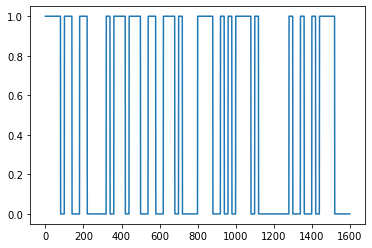

In [431]:
plt.plot(tar)